In [1]:
import numpy as np
import cmath as cm
from numpy import fft
import matplotlib.pyplot as plt

EPS = 1e-12

def get_freq(N):
    arr = np.zeros((N,))
    arr[0:int(N-np.floor(N/2))] = np.array(range(0,int(N-np.floor(N/2))))
    arr[int(N-np.floor(N/2)):N] = np.array(range(0,int(np.floor(N/2)))) - np.floor(N/2)
    return arr

In [11]:
a=np.exp(-0.4*1j)
np.arctan2(a.imag,a.real)

-0.4

In [2]:
def get_mu(M,leng):
    arr = np.zeros((M,))
    arr[0:int(M-np.floor(M/2))] = np.array(range(0,int(M-np.floor(M/2))))
    arr[int(M-np.floor(M/2)):M] = np.array(range(0,int(np.floor(M/2)))) - np.floor(M/2)
    return 2*np.pi*arr/leng
#This code is given by the scheme of Bao Du, so it is intended to translate the Bao Du paramaters to the
#other ones. I mean, if the value of beta you have is calculated for a given epsilon, not 1, 
#then you are expected to divide it by eps^{5/2}


def td_tssp_2d_pbc_bis(M, time_steps, a, b, c, d, psi0, potential, dt, beta, eps, saving_time):

    x = np.linspace(a, b, M, endpoint=False)
    y = np.linspace(c, d, M, endpoint=False)
    X, Y = np.meshgrid(x, y, sparse=False, indexing="ij")
    t = dt * np.arange(time_steps)
    mux = get_mu(M,b-a)
    muy = get_mu(M,d-c)

    Mux, Muy = np.meshgrid(mux, muy, sparse=False, indexing="ij")
    Mu2 = Mux**2 + Muy**2

    psi = np.empty((int(time_steps/saving_time), M, M), dtype=complex)
    psi[0,:] = psi0(X, Y)
    
    V = potential(X, Y) / eps
    zero_pot = (np.abs(V) < EPS).astype(int)
    expV = np.exp(- dt * V )

    p = psi[0,:]

    for i in range(1, time_steps): #Here I divided beta/eps as I think it was necessary for the eq to be valid for eps!=1
        p= _td_tssp_pbc_2d_step_bis(p, dt, beta/eps, eps, x[2]- x[1], y[2]- y[1], \
                                        V, expV, zero_pot, Mu2)
        if i%saving_time==0:
            psi[int(i/saving_time),:] = p
    return t, X, Y, psi



def _td_tssp_pbc_2d_step_bis(psi, dt, beta, eps, dx, dy, V, expV, zero_pot, Mu2):

    abs_psi = np.abs(psi)**2
    p1 = np.empty(psi.shape, dtype=complex)
    p1 = psi * np.where(zero_pot, 1 / np.sqrt(1 + beta*dt * abs_psi), \
                        np.sqrt((V*expV) / (V + beta*(1 - expV)*abs_psi)) )

    p2 = fft.ifft2(fft.fft2(p1) * np.exp(- eps*dt * Mu2 /2))

    abs_p2 = np.abs(p2)**2
    p3 = np.empty(psi.shape, dtype=complex)
    p3 = p2 * np.where(zero_pot, 1 / np.sqrt(1 + beta*dt * abs_p2), \
                        np.sqrt((V*expV) / (V + beta*(1 - expV)*abs_p2)))

    return p3 / np.sqrt(dx*dy * np.sum(np.abs(p3)**2))

def gradient_2d(psi, x_spacing, y_spacing):
    g = np.empty((2, psi.shape[0], psi.shape[1]), dtype=psi.dtype)
    g[0,:] = (-np.roll(psi, 1, axis=0) + psi)/x_spacing
    g[1,:] = (-np.roll(psi, 1, axis=1) + psi)/y_spacing
    return g
def veloc_2d(psi,x_spacing,y_spacing):
    v = np.empty((2, psi.shape[0], psi.shape[1]), dtype=psi.dtype)
    zero_abs = (np.abs(psi)**2 < -5).astype(int)
    v = np.where(zero_abs,0,gradient_2d(psi,x_spacing,y_spacing)*np.conj(psi)-psi*gradient_2d(np.conj(psi),x_spacing,y_spacing))/(1j*np.abs(psi)**2)
    return v

def mean_value_bis(f, psi, a, b, c, d, M):
    dA = (b-a)*(d-c)/(M**2)

    x = np.linspace(a, b, M,endpoint=False)
    y = np.linspace(c, d, M,endpoint=False)
    X, Y = np.meshgrid(x, y, sparse=False, indexing="ij")
    
    return np.sum(f(X,Y) * np.abs(psi)**2)* dA

def energy_gpe(psi, V, beta,eps, x_spacing, y_spacing):#Here we have to use eps to rescale beta, and the potential but also the part with the gradient 
    a = np.abs(psi)
    g = gradient_2d(psi, x_spacing, y_spacing)
    g2 = np.abs(g[0,:])**2 + np.abs(g[1,:])**2
    return x_spacing*y_spacing * np.sum(0.5*g2*eps + V * a**2/eps + 0.5*beta * a**4/eps)
def mu_gpe(psi, V, beta,eps, x_spacing, y_spacing):#Here we have to use eps to rescale beta, and the potential but also the part with the gradient 
    a = np.abs(psi)
    g = gradient_2d(psi, x_spacing, y_spacing)
    g2 = np.abs(g[0,:])**2 + np.abs(g[1,:])**2
    return x_spacing*y_spacing * np.sum(0.5*g2*eps + V * a**2/eps + beta * a**4/eps)

fx= lambda x,y: x
fy= lambda x,y: y
fx2= lambda x,y: x**2
fy2= lambda x,y: y**2

In [4]:
M=256
N=5000
a=-10
b=10
c=-10
d=10
gx=1
gy=1
v=2
w0, delt, r0 = 60, 3,0
potential=lambda x,y:(gx**2*x**2+gy**2*y**2)/2 + w0*np.exp(-delt*((x-r0)**2+y**2)) #notice that the potential is 1/2 instead of 1/4, maybe can discusse it later in more detail 
potential_t=lambda x,y,t:(gx**2*x**2+gy**2*y**2)/2 + w0*np.exp(-delt*((x-r0)**2+(y-v*t)**2))
psi0= lambda x,y: (gx*gy)**(1/4)*np.exp(-(gx**2*x**2+gy**2*y**2)/2)/np.pi**(1/2)

dt=0.001
saving_time=100
eps=2
beta=1000 #Notice that I put twice the value in the paper as later it is diveided by epsilon

In [5]:
t, X, Y, psi=td_tssp_2d_pbc_bis(M, N, a, b, c, d, psi0, potential, dt, beta, eps,saving_time)

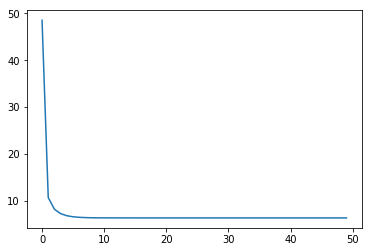

x_rms=2.5421
y_rms=2.542
E_g=6.37242
mu_g=9.21971


In [6]:

V = potential(X, Y)
x_spacing=(b-a)/M
y_spacing=(d-c)/M

En = np.empty(len(psi))
for i in range (len(psi)):
    En[i]=energy_gpe(psi[i], V, beta,eps, x_spacing, y_spacing)
plt.figure()
plt.plot(En)
plt.show()

mu_g = mu_gpe(psi[-1],V,beta,eps,x_spacing,y_spacing)

x_rms = np.sqrt(mean_value_bis(fx2,psi[-1],a,b,c,d,M))
y_rms = np.sqrt(mean_value_bis(fy2,psi[-1],a,b,c,d,M))

print('x_rms={:.5}'.format(x_rms))
print('y_rms={:.4}'.format(y_rms))
print('E_g={:.6}'.format(En[-1]))
print('mu_g={:.6}'.format(mu_g))

<IPython.core.display.Javascript object>


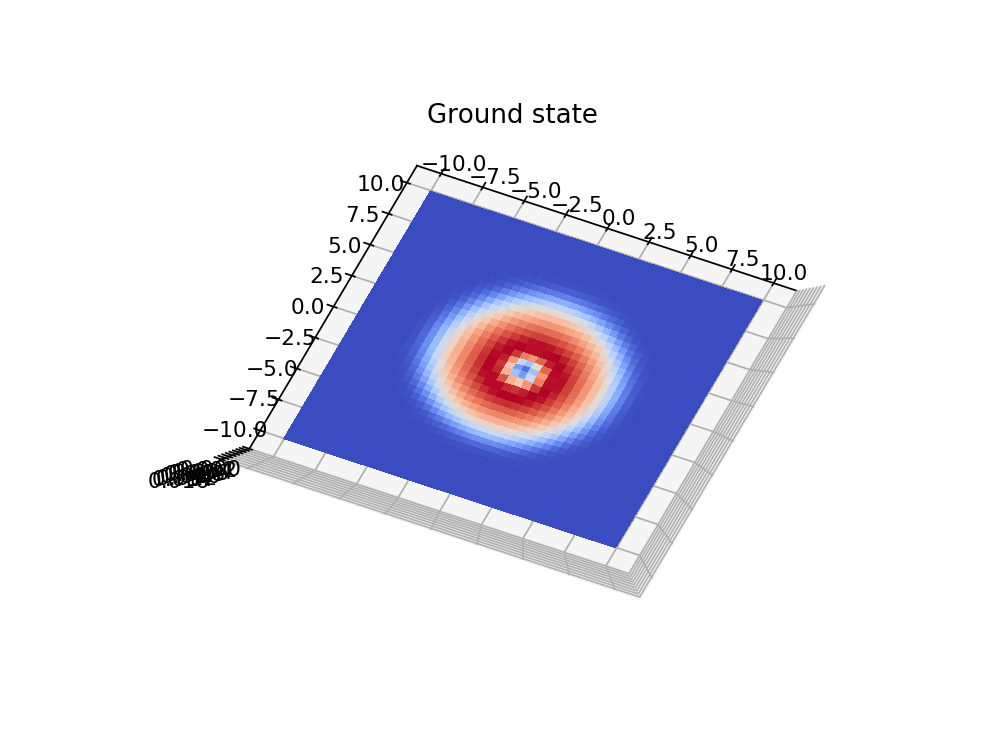

In [6]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

psi2=np.abs(psi)**2
zmax=np.max(psi2[-1])

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_zlim3d(0, zmax)
ax.set_title("Ground state")

surf = ax.plot_surface(X, Y, psi2[-1], cmap=cm.coolwarm,
                   linewidth=0, antialiased=False)

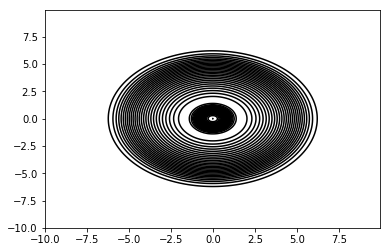

In [7]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

psi2=np.abs(psi)**2
zmax=np.max(psi2[-1])

fig = plt.figure()
plt.contour(X,Y,psi2[-1],30,vmax=zmax,colors='black')

In [8]:

def TSSP2D_opt(M,N,q,a,b,psi0,potential,dt,k1,eps):
    # 1/q is the fraction of the times we want to store. q must devide N
    
    n=int(N/q)
    x=np.linspace(a,b,M,endpoint=False)
    y=np.linspace(a,b,M,endpoint=False)
    x,y=np.meshgrid(x,y,sparse=False,indexing="ij")
    t=np.linspace(0,N*dt,n,endpoint=False)
    freq=get_freq(M)
    freqx,freqy=np.meshgrid(freq,freq,sparse=False,indexing="ij")
    
    psi=np.zeros((n,M,M),dtype=complex)
    psi[0,:]=psi0
    
    for i in range (1,n):
        ps = psi[i-1]
        
        ps = ps*np.exp(-1j*(potential(x,y,t[i])+k1*np.abs(ps)**2)*dt/(2*eps))
        ps = np.fft.ifft2(np.fft.fft2(ps)*np.exp(-1j*(eps/2)*dt*4*np.pi**2*(freqx**2+freqy**2)/(b-a)**2))
        
        for j in range(q-1):
        
            ps = ps*np.exp(-1j*(potential(x,y,t[i]+dt*j)+k1*np.abs(ps)**2)*dt/(eps))

            ps = np.fft.ifft2(np.fft.fft2(ps)*np.exp(-1j*(eps/2)*dt*4*np.pi**2*(freqx**2+freqy**2)/(b-a)**2))
        
        psi[i] = ps*np.exp(-1j*(potential(x,y,t[i]+dt*j)+k1*np.abs(ps)**2)*dt/(2*eps))
        
    return t,x,y,psi

In [9]:
t,x,y,psi_t=TSSP2D_opt(M,7000,50,a,b,psi[-1],potential_t,dt,beta,eps)

Now the functions to determine the phase, and the phase slip.
What I think I am doing is exactly what they proppose. Calculate the phase at each point along the line in which the "object is moving", i.e. the $y$ axis. So, along the axis I compute the phase at every point:
$$
\arg(\psi(0,y,t))
$$
To compute the phase what I am doing is to determine 
$$
\arctan(Im(\psi(0,y,t))/Re(\psi(0,y,t)))
$$
and then determine the phase slip by doing
$$
\Delta S(0,y,t)=\arg(\psi(0,y+\Delta y,t))-\arg(\psi(0,y,t))
$$
As you will see it is doing something very strange which is independent actually of the way to calculate $\Delta S$. It is enough to look at the behavior of the phase against $y$

In [38]:
def calc_phase(ps):
    phases = np.empty(len(ps))
    #zero_abs = (np.abs(ps)**2 < -10**(-2)).astype(int)
    phases=np.arctan2(ps.imag,(ps.real))
    return phases
#Here I only calculate the phase for the values of y greatter than zero, which are in fact the relevant ones
def delta_S(psi_time,M):
    phases=np.zeros((len(psi_time),int(M/2)))
    dif_phase=np.zeros((len(psi_time),int(M/2)))
    
    for i in range(len(psi_time)):
        phases[i]=calc_phase(psi_time[i][int(M/2)][int(M/2):])
        dif_phase[i]=(-np.roll(phases[i],1)+phases[i])
    return phases,dif_phase


phases,delta_phase=delta_S(psi_t,M) 


In [50]:
x=psi_t[10][int(M/2)][int(M/2)+10]
np.arctan2(x.imag,x.real),phases[10][10],X[int(M/2)][int(M/2)+10],Y[int(M/2)][int(M/2)+10]

(2.483233641747336, 2.483233641747336, 0.0, 0.78125)

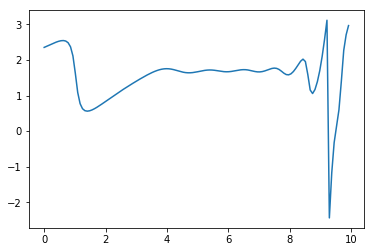

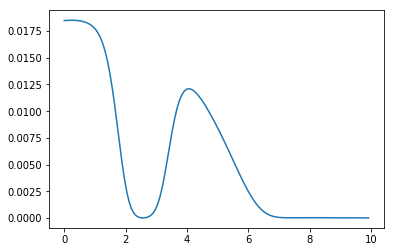

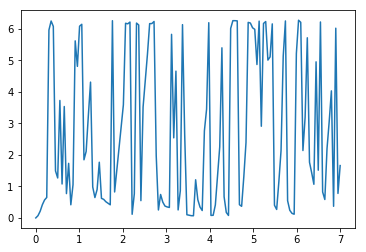

In [39]:
#Plot of the phase
plt.figure()
y=np.linspace(0,b,int(M/2),endpoint=False)
plt.plot(y,phases[10])
plt.show()
#Plot of the variation of the phase 
plt.figure()
y=np.linspace(0,b,int(M/2),endpoint=False)
plt.plot(y,np.abs(psi_t[25][int(M/2)][int(M/2):])**2)
plt.show()
#To determine the maximum difference in phase at every stored time
maxd=np.zeros(len(delta_phase))
for i in range(len(delta_phase)):
    maxd[i]=np.max(delta_phase[i])
#Plot of the maximum difference in phase at every stored time
plt.figure()
t=np.linspace(0,len(psi_t)*50*dt,len(psi_t))
plt.plot(t,maxd)
plt.show()

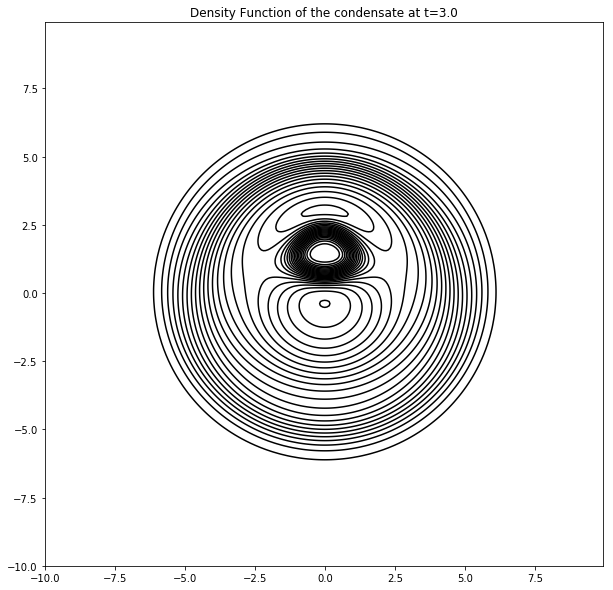

In [314]:
psi2=np.abs(psi_t[14])**2
extent=(-7.5,7.5,-7.5,7.5)
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Density Function of the condensate at t=3.0')
ax.axis=([-7.5,7.5,-7.5,7.5])
cs=ax.contour(X,Y,psi2,25,colors='black',extent=extent)
plt.show()

/home/lopetegui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in true_divide
/home/lopetegui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
/home/lopetegui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/home/lopetegui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide


In [97]:
len(psi)

140

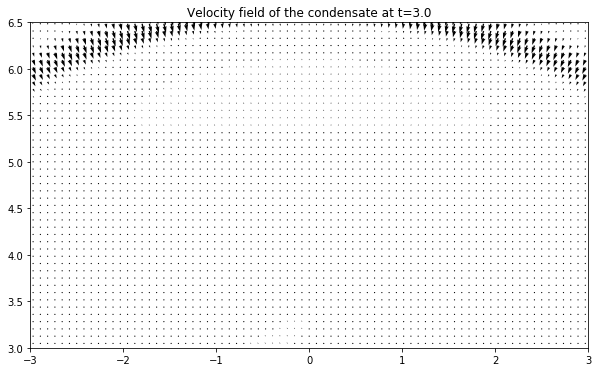

In [18]:
for i in range (1):
    u,v=veloc_2d(psi_t[21],x_spacing,y_spacing)
    for i in range(len(X)):
        for j in range(len(Y[0])):
            if (X[i][j]<-5 or X[i][j]>5) or (Y[i][j]<-1 or Y[i][j]>8):
                u[i][j] =0
                v[i][j] =0
            else:
                u[i][j] =u[i][j]
                v[i][j] =v[i][j]
    fig, ax = plt.subplots(figsize=(10,10))
    ax.quiver(X,Y,u,v,scale=500)
    ax.axis([-3,3,3,6.5])
    ax.set_aspect('equal')
    ax.set_title('Velocity field of the condensate at t=3.0')
    plt.show()#I will upgrade the graphic, sorry it is kind of basic still

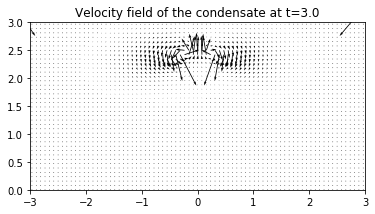

In [23]:
u,v=veloc_2d(psi_t[24],x_spacing,y_spacing)
for i in range(len(X)):
        for j in range(len(Y[0])):
            if (X[i][j]<-5 or X[i][j]>5) or (Y[i][j]<-1 or Y[i][j]>6):
                u[i][j] =0
                v[i][j] =0
            else:
                u[i][j] =u[i][j]
                v[i][j] =v[i][j]
fig, ax = plt.subplots()
ax.quiver(X,Y,u,v,scale=500)
ax.axis([-3,3, 0,3])
ax.set_aspect('equal')
ax.set_title('Velocity field of the condensate at t=3.0')
plt.show()#I will upgrade the graphic, sorry it is kind of basic still

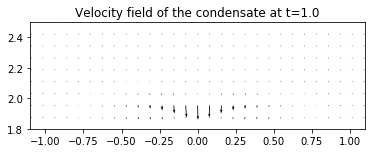

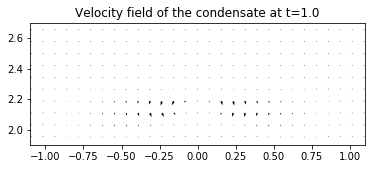

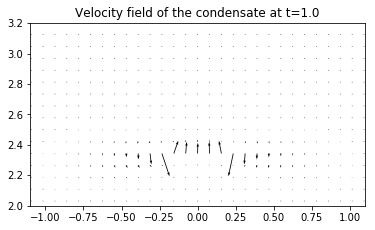

In [68]:
u,v=veloc_2d(psi_t[19],x_spacing,y_spacing)
fig, ax = plt.subplots()
ax.quiver(X,Y,40000*u,40000*v)
ax.axis([-1.1,1.1,1.8,2.5])
ax.set_aspect('equal')
ax.set_title('Velocity field of the condensate at t=1.0')
plt.show()#I will upgrade the graphic, sorry it is kind of basic still
u,v=veloc_2d(psi_t[21],x_spacing,y_spacing)
fig, ax = plt.subplots()
ax.quiver(X,Y,40000*u,40000*v)
ax.axis([-1.1,1.1,1.9,2.7])
ax.set_aspect('equal')
ax.set_title('Velocity field of the condensate at t=1.0')
plt.show()#I will upgrade the graphic, sorry it is kind of basic still
u,v=veloc_2d(psi_t[23],x_spacing,y_spacing)
fig, ax = plt.subplots()
ax.quiver(X,Y,40000*u,40000*v)
ax.axis([-1.1,1.1,2,3.2])
ax.set_aspect('equal')
ax.set_title('Velocity field of the condensate at t=1.0')
plt.show()#I will upgrade the graphic, sorry it is kind of basic still

<IPython.core.display.Javascript object>


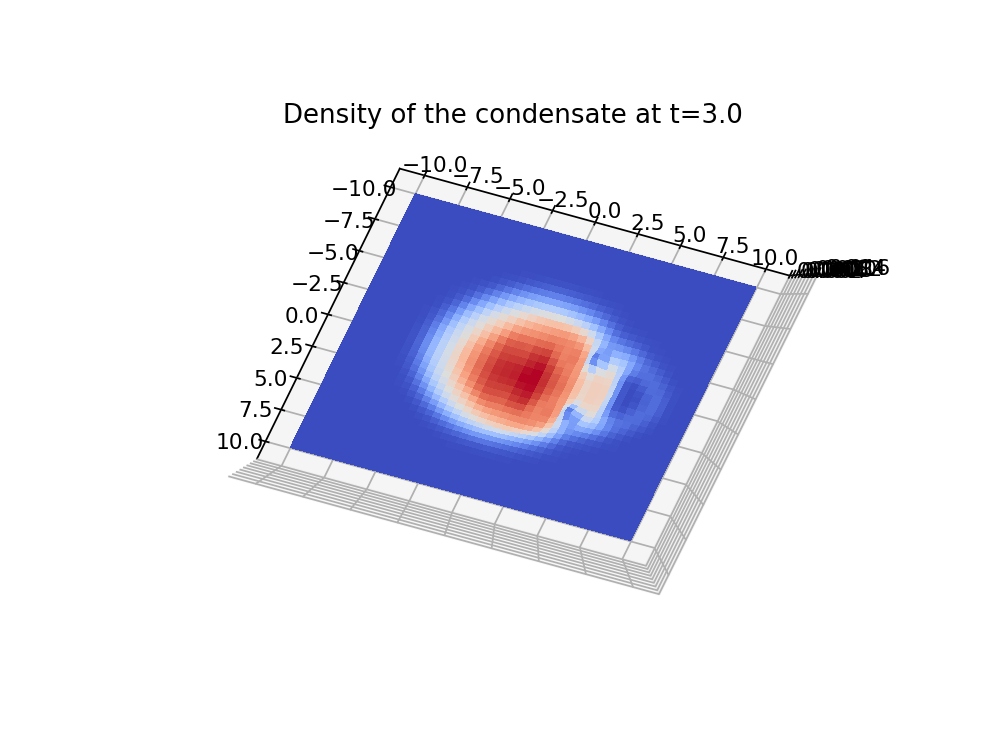

In [96]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

psi2=np.abs(psi[61])**2

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_zlim3d(0, zmax)
ax.set_title("Density of the condensate at t=3.0")

surf = ax.plot_surface(X, Y, psi2, cmap=cm.coolwarm,
                   linewidth=0, antialiased=False)

<IPython.core.display.Javascript object>


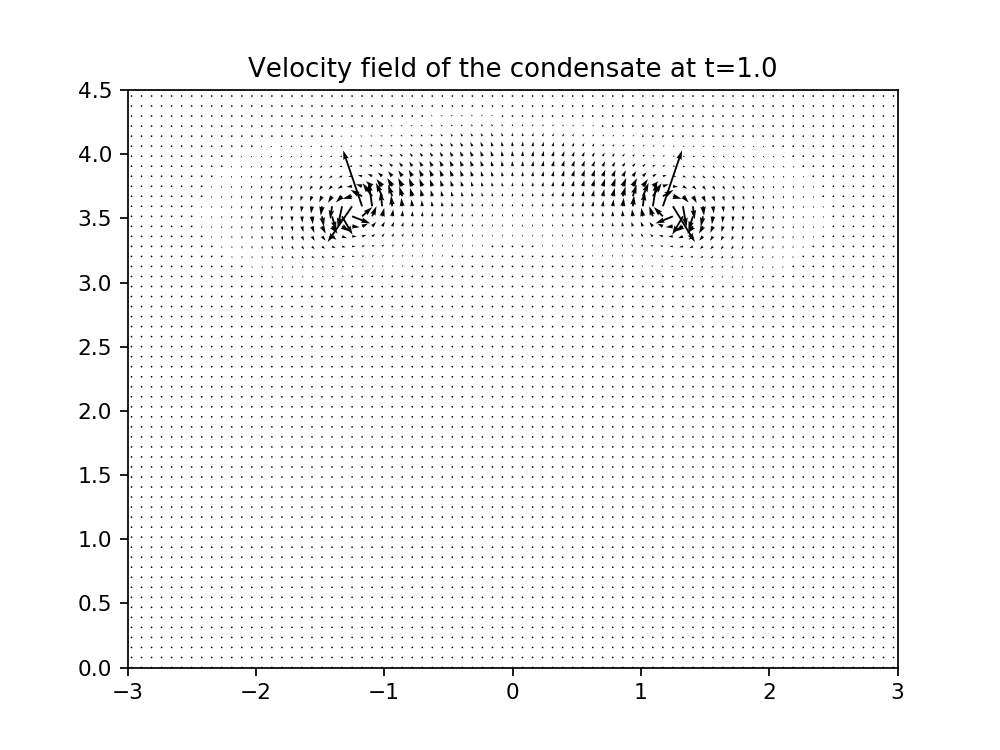

<IPython.core.display.Javascript object>


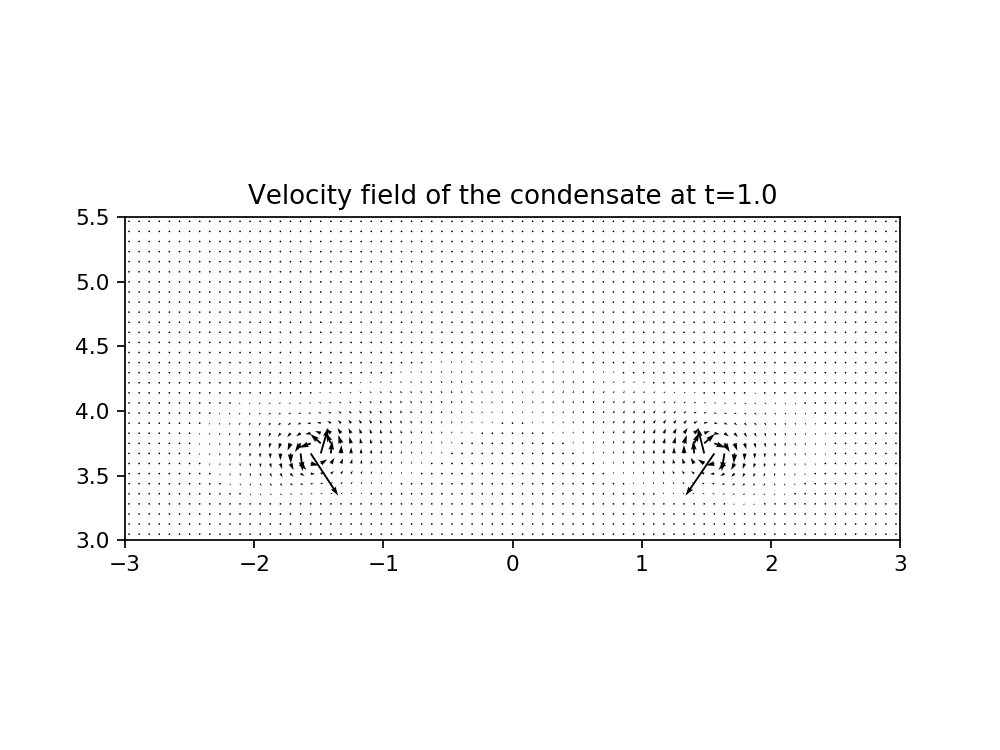

<IPython.core.display.Javascript object>


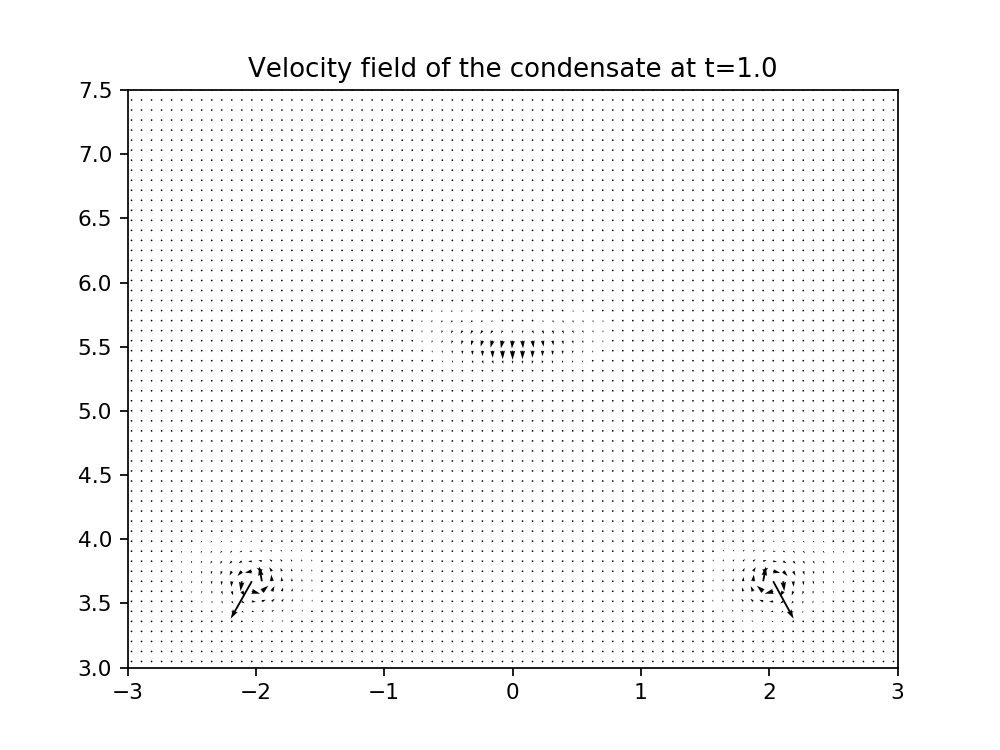

<IPython.core.display.Javascript object>


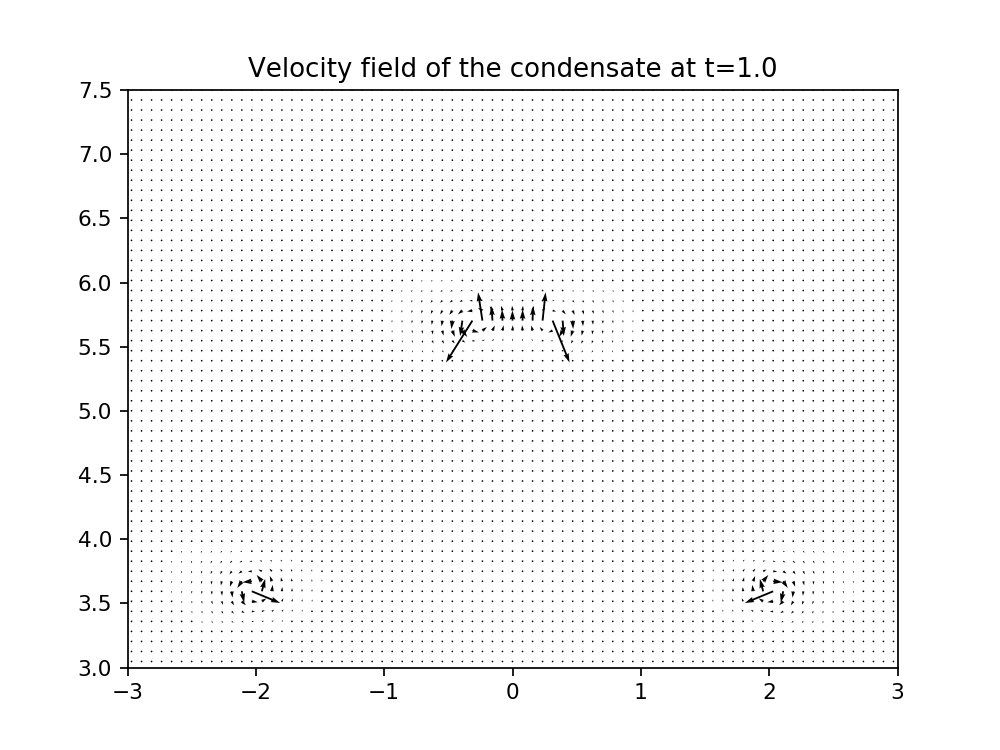

<IPython.core.display.Javascript object>


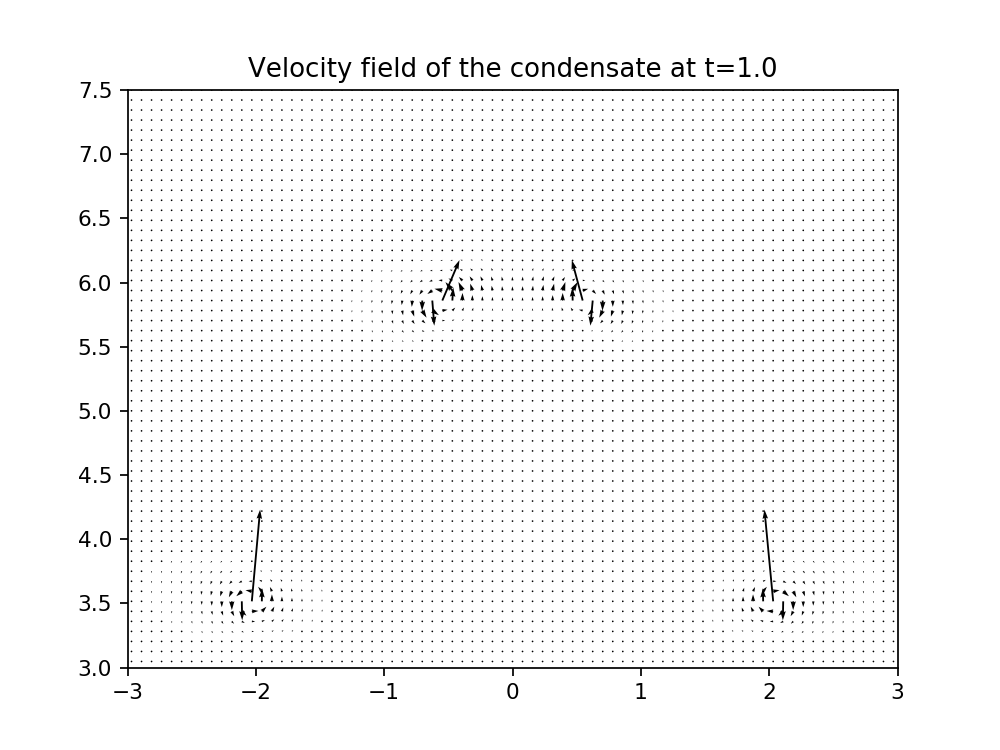

In [70]:
u,v=veloc_2d(psi_t[40],x_spacing,y_spacing)
fig, ax = plt.subplots()
ax.quiver(X,Y,40000*u,40000*v)
ax.axis([-3,3,0,4.5])
ax.set_aspect('equal')
ax.set_title('Velocity field of the condensate at t=1.0')
plt.show()#I will upgrade the graphic, sorry it is kind of basic still
u,v=veloc_2d(psi_t[45],x_spacing,y_spacing)
fig, ax = plt.subplots()
ax.quiver(X,Y,40000*u,40000*v)
ax.axis([-3,3,3,5.5])
ax.set_aspect('equal')
ax.set_title('Velocity field of the condensate at t=1.0')
plt.show()#I will upgrade the graphic, sorry it is kind of basic still
u,v=veloc_2d(psi_t[55],x_spacing,y_spacing)
fig, ax = plt.subplots()
ax.quiver(X,Y,40000*u,40000*v)
ax.axis([-3,3,3,7.5])
ax.set_aspect('equal')
ax.set_title('Velocity field of the condensate at t=1.0')
plt.show()#I will upgrade the graphic, sorry it is kind of basic still


u,v=veloc_2d(psi_t[57],x_spacing,y_spacing)
fig, ax = plt.subplots()
ax.quiver(X,Y,40000*u,40000*v)
ax.axis([-3,3,3,7.5])
ax.set_aspect('equal')
ax.set_title('Velocity field of the condensate at t=1.0')
plt.show()#I will upgrade the graphic, sorry it is kind of basic still
u,v=veloc_2d(psi_t[59],x_spacing,y_spacing)
fig, ax = plt.subplots()
ax.quiver(X,Y,40000*u,40000*v)
ax.axis([-3,3,3,7.5])
ax.set_aspect('equal')
ax.set_title('Velocity field of the condensate at t=1.0')
plt.show()

In [62]:
np.roll(X, 1, axis=0)

array([[  9.921875,   9.921875,   9.921875, ...,   9.921875,   9.921875,
          9.921875],
       [-10.      , -10.      , -10.      , ..., -10.      , -10.      ,
        -10.      ],
       [ -9.921875,  -9.921875,  -9.921875, ...,  -9.921875,  -9.921875,
         -9.921875],
       ...,
       [  9.6875  ,   9.6875  ,   9.6875  , ...,   9.6875  ,   9.6875  ,
          9.6875  ],
       [  9.765625,   9.765625,   9.765625, ...,   9.765625,   9.765625,
          9.765625],
       [  9.84375 ,   9.84375 ,   9.84375 , ...,   9.84375 ,   9.84375 ,
          9.84375 ]])

In [80]:
X

array([[-10.      , -10.      , -10.      , ..., -10.      , -10.      ,
        -10.      ],
       [ -9.921875,  -9.921875,  -9.921875, ...,  -9.921875,  -9.921875,
         -9.921875],
       [ -9.84375 ,  -9.84375 ,  -9.84375 , ...,  -9.84375 ,  -9.84375 ,
         -9.84375 ],
       ...,
       [  9.765625,   9.765625,   9.765625, ...,   9.765625,   9.765625,
          9.765625],
       [  9.84375 ,   9.84375 ,   9.84375 , ...,   9.84375 ,   9.84375 ,
          9.84375 ],
       [  9.921875,   9.921875,   9.921875, ...,   9.921875,   9.921875,
          9.921875]])

In [2]:
a=1j+2

In [6]:
cm.phase(a)

0.4636476090008061

In [8]:
np.arctan(1/2)

0.4636476090008061

1.0

In [ ]:
a